# DAC: Deep Autoencoder-based Clustering, A General Deep Learning Framework of Representation Learning

- **Name:** Mohammad Mahdi Salmani

## 1. Import Libraries

In [ ]:
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## 2. Check device

In [ ]:
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 3. Define a custom autoencoder class

In [ ]:
class CustomAutoencoder(nn.Module):
    def __init__(self):
        super(CustomAutoencoder, self).__init__()
        self.normalize = nn.BatchNorm1d(784)
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Tanh(),
            nn.Linear(128, 32),
            nn.Tanh(),
            nn.Linear(32, 10),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(10, 32),
            nn.Tanh(),
            nn.Linear(32, 128),
            nn.Tanh(),
            nn.Linear(128, 512),
            nn.Tanh(),
            nn.Linear(512, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.normalize(x).cuda()
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## 4. Define the hyperparameters and load datas

### 4.1. Load MNIST dataset and create data loaders

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders for training and testing
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 53182533.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28435608.88it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 70561680.17it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14976830.79it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### 4.2. Load weights and autoencoder if already saved (*Optional*)

In [ ]:
# Load the weightslist if already calculated
if not 'mse_weights' in globals():
    mse_weights = torch.load('mse_weights.pt',map_location=torch.device(device))
    # print(len(mse_weights))

# Load the trained autoencoder model if already trained
if not 'autoencoder' in globals():
    autoencoder = CustomAutoencoder().to(device)
    autoencoder.load_state_dict(torch.load('autoencoder_model.pth'))
    autoencoder.eval()  # Set the model to evaluation mode

## 5. Calculate weights for each pixel

In [ ]:
from math import exp

# Select a subset to calculate weights for each pixel
sub_set_dataset = torch.utils.data.Subset(train_dataset,list(range(0, len(train_dataset), 1000))) # num: 60
print('subset num: ',len(sub_set_dataset))

i = 0
mse_weights = torch.zeros(28 * 28)
for i in range(28 * 28):
    # calculate weight for each pixel
    sum_1 = sum_2 = 0.0
    num_1 = num_2 = 0.0
    for p in sub_set_dataset:
        x_p, l_p = p
        x_p = x_p.view(-1)
        for q in sub_set_dataset:
            x_q, l_q = q
            x_q = x_q.view(-1)
            if l_p == l_q:
                num_1 += 1
                sum_1 += exp(-((x_p[i] - x_q[i]) ** 2))
            else:
                num_2 += 1
                sum_2 += 1 - exp(-((x_p[i] - x_q[i]) ** 2))
    mse_weights[i] = (sum_1 / num_1) * (sum_2 / num_2)

# Move weights tensor to GPU
mse_weights = mse_weights.to(device)

# Save results
torch.save(mse_weights, 'mse_weights.pt')

sub set num:  60


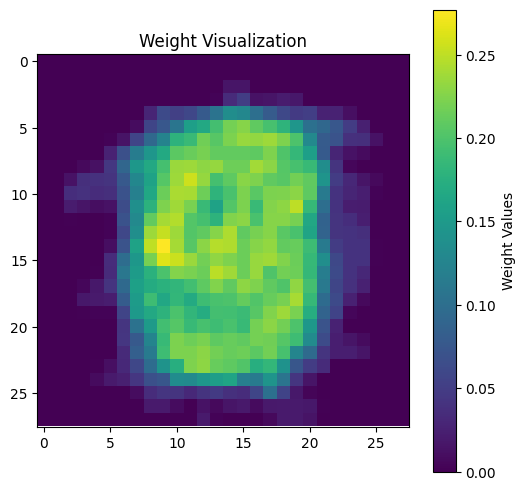

In [ ]:
import matplotlib.pyplot as plt

# Reshape the 'weights' tensor into a 28x28 grid
weight_grid = mse_weights.view(28, 28).cpu().numpy()

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(weight_grid, cmap='viridis')  # You can choose a colormap of your choice

# Show the colorbar if needed
cbar = ax.figure.colorbar(ax.imshow(weight_grid), ax=ax)
cbar.ax.set_ylabel('Weight Values')

# Show the plot
plt.title("Weight Visualization")
plt.show()


## 6. Define customize loss function

In [ ]:
from torch import Tensor

beta = 0.00001

class CustomAutoencoderLoss(nn.modules.loss._Loss):
    def __init__(self, mse_weight: Tensor):
        super(CustomAutoencoderLoss, self).__init__()
        self.mse_weight = mse_weight

    def forward(self, input: Tensor, target: Tensor, parameters):
        # Wm weighted MSE loss
        L_cmse = torch.sum(self.mse_weight * ((input - target) ** 2)) / len(self.mse_weight)

        # L2 regularization
        l2_regularization = sum(torch.norm(param, p=2) for param in parameters)

        loss = L_cmse + beta * l2_regularization

        return loss

## 7. Train and test the autoencoder model

In [ ]:
# define autoencoder
autoencoder = CustomAutoencoder().to(device)

# define loss funcion
custom_loss = CustomAutoencoderLoss(mse_weights).to(device)

# define optimizer
learning_rate = 0.003
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)


In [ ]:
num_epochs = 100

# Train the model
for epoch in range(num_epochs):
    for (inputs, _) in train_loader:
        inputs = inputs.view(inputs.size(0), -1).cuda()
        outputs = autoencoder(inputs)
        loss = custom_loss(inputs,outputs.cuda(),autoencoder.parameters())  # Pass the encoded representation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 0.1579
Epoch [2/100], Loss: 0.1568
Epoch [3/100], Loss: 0.1411
Epoch [4/100], Loss: 0.1228
Epoch [5/100], Loss: 0.1229
Epoch [6/100], Loss: 0.1206
Epoch [7/100], Loss: 0.1095
Epoch [8/100], Loss: 0.1054
Epoch [9/100], Loss: 0.1147
Epoch [10/100], Loss: 0.1009
Epoch [11/100], Loss: 0.0901
Epoch [12/100], Loss: 0.1163
Epoch [13/100], Loss: 0.0940
Epoch [14/100], Loss: 0.1129
Epoch [15/100], Loss: 0.1007
Epoch [16/100], Loss: 0.1036
Epoch [17/100], Loss: 0.1262
Epoch [18/100], Loss: 0.1092
Epoch [19/100], Loss: 0.1127
Epoch [20/100], Loss: 0.1131
Epoch [21/100], Loss: 0.1057
Epoch [22/100], Loss: 0.1013
Epoch [23/100], Loss: 0.1048
Epoch [24/100], Loss: 0.1049
Epoch [25/100], Loss: 0.1124
Epoch [26/100], Loss: 0.0975
Epoch [27/100], Loss: 0.1059
Epoch [28/100], Loss: 0.0971
Epoch [29/100], Loss: 0.0952
Epoch [30/100], Loss: 0.0999
Epoch [31/100], Loss: 0.0975
Epoch [32/100], Loss: 0.0915
Epoch [33/100], Loss: 0.0934
Epoch [34/100], Loss: 0.1025
Epoch [35/100], Loss: 0

In [ ]:
# Save the trained model
torch.save(autoencoder.state_dict(), 'autoencoder_model.pth')

## 8. Visualize some reconstructed images

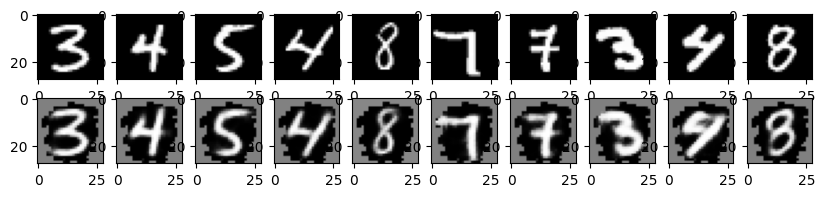

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    for (inputs, _) in train_loader:
        inputs = inputs.view(inputs.size(0), -1).to(device)
        outputs = autoencoder(inputs)
        break

    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        axes[0, i].imshow(inputs[i].view(28, 28).cpu().numpy(), cmap='gray')
        axes[1, i].imshow(outputs[i].view(28, 28).cpu().numpy(), cmap='gray')

    plt.show()

## 9. Clustering with K-Means algorithm

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

labels = []
encoded_data = []

for inputs, label in train_loader.dataset:
    labels.append(label)
    inputs = inputs.view(-1).to(device)
    with torch.no_grad():
        encoder = autoencoder.encoder(inputs)
        encoded_data.append(encoder.cpu().numpy())

# Extract the encoded representations from the data
encoded_data = np.array(encoded_data)
# The labels assigned by K-Means to each data point
labels = np.array(labels)

# Perform K-Means clustering on the encoded data
n_clusters = 10  # number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
cluster_labels = kmeans.fit_predict(encoded_data)


## 10. Evaluate our framework

In [ ]:
# Calculate the ARI
ari = adjusted_rand_score(labels_pred=cluster_labels, labels_true=labels)
print(f'Adjusted Rand Index (ARI): {ari:.4f}')

Adjusted Rand Index (ARI): 0.4733


In [ ]:
data, labels = next(iter(train_loader))
data = data.view(data.size(0), -1).to(device)
labels = labels.numpy()

# Sets the module in evaluation mode
with torch.no_grad():
    autoencoder.eval()
    encoded_data = autoencoder.encoder(data).cpu().numpy()

kmeans_enocoded = KMeans(n_clusters=10, n_init=10)
cluster_labels = kmeans_enocoded.fit_predict(encoded_data)

# Calculate the ARI
ari = adjusted_rand_score(labels_pred=cluster_labels, labels_true=labels)
print(f'Adjusted Rand Index (ARI): {ari:.4f}')

Adjusted Rand Index (ARI): 0.0504


In [ ]:
# Cluster K-Means with 784 inputs
kmeans_enocoded = KMeans(n_clusters=10, n_init=10)
cluster_labels = kmeans_enocoded.fit_predict(data)
# Calculate the ARI
ari = adjusted_rand_score(labels_pred=cluster_labels, labels_true=labels)
print(f'Adjusted Rand Index (ARI): {ari:.4f}')

Adjusted Rand Index (ARI): 0.2048
